In [1]:
import cv2 # OpenCV library
import numpy as np # Numpy library for scientific computing
import matplotlib.pyplot as plt # Matplotlib library for plotting
import math

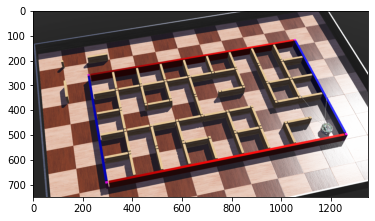

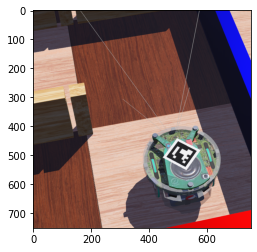

In [2]:
maze = cv2.imread('../TEST/Maze_3.png')
maze_rgb = cv2.cvtColor(maze, cv2.COLOR_BGR2RGB)
plt.imshow(maze_rgb)
plt.show()
# image is loaded with imread command 
robot_bgr = cv2.imread('../TEST/Robot_3.png')
robot_rgb = cv2.cvtColor(robot_bgr,cv2.COLOR_BGR2RGB)
plt.imshow(robot_rgb)
plt.show()

(<matplotlib.image.AxesImage at 0x7fb6c85db190>,
 Text(0.5, 1.0, 'Contour of Corner Stones'))

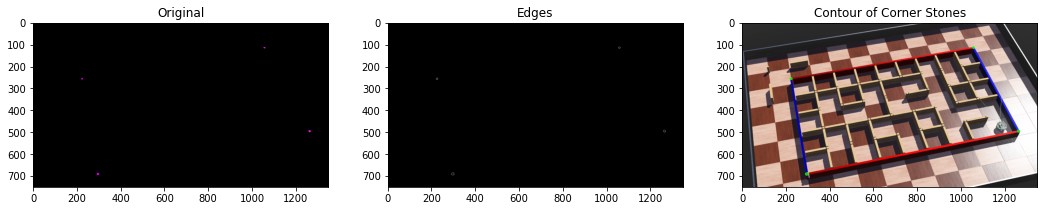

In [3]:
olower = np.array([130, 200, 104])
oupper = np.array([150,255,255])

#convert to hsv
hsv = cv2.cvtColor(maze, cv2.COLOR_BGR2HSV)
#create mask
corner_mask = cv2.inRange(hsv, olower, oupper)
result = cv2.bitwise_and(maze, maze, mask=corner_mask)

#Opening
mask_opened = cv2.morphologyEx(corner_mask, cv2.MORPH_OPEN, kernel = np.ones((3,3), np.uint8))
mask_3_channel = cv2.cvtColor(mask_opened, cv2.COLOR_GRAY2BGR)
#plt.imshow(mask_3_channel)
numpy_horizontal = np.hstack((maze, result, mask_3_channel))

img_bgr = result
img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
img_rgb_origin = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
edges = cv2.Canny(mask_opened, threshold1 = 50, threshold2 = 100, apertureSize = 3)


# Find contours from edges
img2, contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# Draw them on maze
cv2.drawContours(maze, contours, -1, (0,255,0),3)
# Cvt maze to RGB
img_rgb = cv2.cvtColor(maze, cv2.COLOR_BGR2RGB)
# disp maze
#plt.imshow(img_rgb)
# Plot the image
fig, (ax1,ax2,ax3) = plt.subplots(figsize = (18,10), ncols = 3)
ax1.imshow(img_rgb_origin), ax1.set_title("Original")
ax2.imshow(edges, cmap='gray'), ax2.set_title("Edges")
ax3.imshow(img_rgb), ax3.set_title("Contour of Corner Stones")

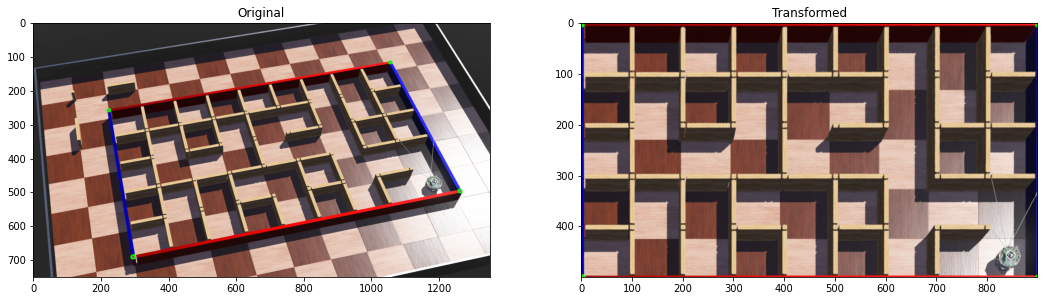

In [4]:
source = [[],[],[],[]]
# calculate MOI
for i, cnt in enumerate(contours):
    (x,y), r = cv2.minEnclosingCircle(cnt)
    point = [int(x), int(y)]
    
    if point[0] <= 337.5 and point[1] <=375: #top left
        source[0] = point
    elif point[0] >= 1012.5 and point[1] <= 375: #top right
        source[1] = point
    elif point[0] <= 337.5 and point[1] > 375: #bottom left
        source[2] = point
    elif point[0] >= 1012.5 and point[1] > 375: #bottom right
        source[3] = point
    

source = np.float32(source)


pts = np.float32([[0,0], [900,0], [0,500], [900,500]])
#pts = np.float32([[0,500], [900,500], [0,0], [900,0]])

H = cv2.getPerspectiveTransform(source,pts) # homography matrix

tsf = cv2.warpPerspective(maze, H, (900,500))
tsf_rgb = cv2.cvtColor(tsf, cv2.COLOR_BGR2RGB)

fig, (ax1, ax2) = plt.subplots(figsize = (18, 10), ncols = 2)
ax1.imshow(img_rgb), ax1.set_title("Original")
ax2.imshow(tsf_rgb), ax2.set_title("Transformed")
plt.show()

(<matplotlib.image.AxesImage at 0x7fb6cba78e10>,
 Text(0.5, 1.0, 'After Wall Mask'))

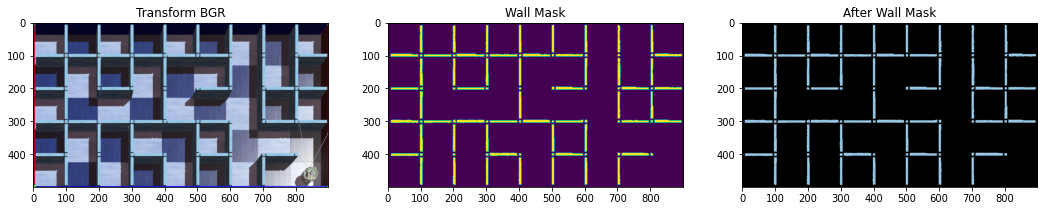

In [5]:
# detecting inner walls
iH = [12, 179]
iS = [5, 145]
iV = [225, 255]
ilower = np.array([iH[0],iS[0],iV[0]])
iupper = np.array([iH[1],iS[1],iV[1]])
#convert to hsv 
tsf_hsv = cv2.cvtColor(tsf, cv2.COLOR_BGR2HSV)
#create mask
in_mask = cv2.inRange(tsf_hsv, ilower, iupper)
in_mask = cv2.morphologyEx(in_mask, cv2.MORPH_OPEN, kernel = np.ones((3,3), np.uint8))
in_result = cv2.bitwise_and(tsf, tsf, mask=in_mask)

fig, (ax1, ax2, ax3) = plt.subplots(figsize = (18, 10), ncols = 3)
ax1.imshow(tsf), ax1.set_title("Transform BGR")
ax2.imshow(in_mask), ax2.set_title("Wall Mask")
ax3.imshow(in_result), ax3.set_title("After Wall Mask")


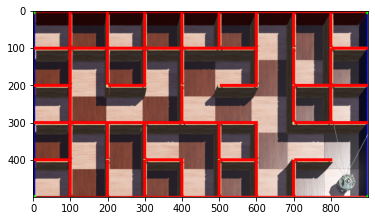

In [6]:
# Drawing lines on inner walls
row, col, chan = tsf_rgb.shape
#maze_tf = cv2.cvtColor(tsf_rgb, cv2.COLOR_HSV2RGB)
maze_tf = tsf_rgb
vWall = np.zeros((5,9))
hWall = np.zeros((5,9))
thickness = 4
# read walls
for i in range(5):
    for j in range(9):
        for k in range(6):
            if in_mask[i*100+50, j*100+k] == 255 or in_mask[i*100+50, j*100-k]:
                vWall[i][j] = 1
            if in_mask[i*100-k, j*100+50] == 255 or in_mask[i*100+k, j*100+50] == 255:
                hWall[i][j] = 1

# draw
for i in range(5):
    for j in range(9):
        if vWall[i][j] == 1:
            maze_tf[i*100:i*100+100-2, j*100-thickness:j*100+thickness, :] = [255,0,0]
        if hWall[i][j] == 1:
            maze_tf[i*100-thickness:i*100+thickness, j*100+2:j*100+100+4, :] = [255,0,0]
            
plt.imshow(maze_tf)
plt.show()

In [7]:
'''# Drawing lines on inner walls
row, col, chan = tsf_rgb.shape
#maze_tf = cv2.cvtColor(tsf_rgb, cv2.COLOR_HSV2RGB)
maze_tf = tsf_rgb
vWall = np.zeros((5,9))
hWall = np.zeros((5,9))
thickness = 3
# read walls
for i in range(5):
    for j in range(9):
        if in_mask[i*100+50, j*100] == 255:
            vWall[i][j] = 1
        if in_mask[i*100, j*100+50] == 255:
            hWall[i][j] = 1

# draw
for i in range(5):
    for j in range(9):
        if vWall[i][j] == 1:
            maze_tf[i*100:i*100+100-2, j*100-thickness:j*100+thickness, :] = [255,0,0]
        if hWall[i][j] == 1:
            maze_tf[i*100-thickness:i*100+thickness, j*100+2:j*100+100+4, :] = [255,0,0]
            
plt.imshow(maze_tf)
plt.show()'''

'# Drawing lines on inner walls\nrow, col, chan = tsf_rgb.shape\n#maze_tf = cv2.cvtColor(tsf_rgb, cv2.COLOR_HSV2RGB)\nmaze_tf = tsf_rgb\nvWall = np.zeros((5,9))\nhWall = np.zeros((5,9))\nthickness = 3\n# read walls\nfor i in range(5):\n    for j in range(9):\n        if in_mask[i*100+50, j*100] == 255:\n            vWall[i][j] = 1\n        if in_mask[i*100, j*100+50] == 255:\n            hWall[i][j] = 1\n\n# draw\nfor i in range(5):\n    for j in range(9):\n        if vWall[i][j] == 1:\n            maze_tf[i*100:i*100+100-2, j*100-thickness:j*100+thickness, :] = [255,0,0]\n        if hWall[i][j] == 1:\n            maze_tf[i*100-thickness:i*100+thickness, j*100+2:j*100+100+4, :] = [255,0,0]\n            \nplt.imshow(maze_tf)\nplt.show()'

North


(<matplotlib.image.AxesImage at 0x7fb6cab49c50>, Text(0.5, 1.0, 'Transformed'))

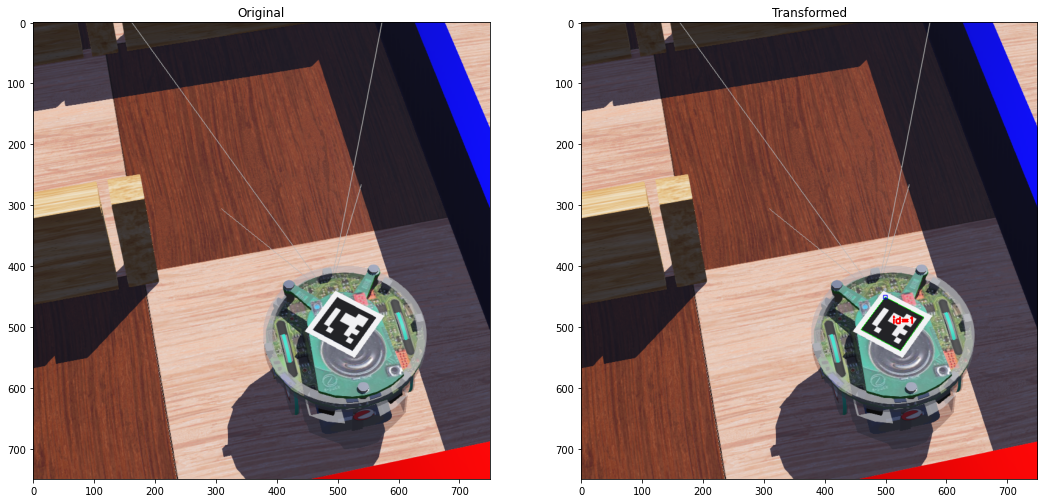

In [8]:
# Detect ArUco markers
# Perspective transform the robot
#robot_tf = cv2.warpPerspective(robot_rgb, H, (900,900))
robot_tf = robot_rgb.copy()
# Load the predefined dictionary
dictionary = cv2.aruco.Dictionary_get(cv2.aruco.DICT_6X6_250)

# Initialize the detector parameters using default values
parameters =  cv2.aruco.DetectorParameters_create()

# Detect the markers in the image
markerCorners, markerIds, rejectedCandidates = cv2.aruco.detectMarkers(robot_tf, dictionary, parameters=parameters)
#markerCorners are N, E, S, W
marker = cv2.aruco.drawDetectedMarkers(robot_tf, markerCorners, markerIds)

heading = 0 # N, E, S, W
head = ""

m = (markerCorners[0][0][0][1]-markerCorners[0][0][1][1])/(markerCorners[0][0][0][0]-markerCorners[0][0][1][0])

# if slope is negative
if m < 0:
    # if xhead > xright
    if markerCorners[0][0][0][0]>markerCorners[0][0][1][0]:
        heading = 1 # East
    else:
        heading = 3 # West
else:
    # if xhead < xright
    if markerCorners[0][0][0][0]>markerCorners[0][0][1][0]:
        heading = 2 # South
    else:
        heading = 0 # North

if heading == 0:
    print('North')
    head = "^"
elif heading == 1:
    print('Ease')
    head = ">"
elif heading == 2:
    print('South')
    head = "v"
elif heading == 3:
    print('West')
    head = "<"
    
fig, (ax1, ax2) = plt.subplots(figsize = (18, 10), ncols = 2)
ax1.imshow(robot_rgb), ax1.set_title("Original")
ax2.imshow(robot_tf), ax2.set_title("Transformed")


843.7567749023438 461.2432556152344
26


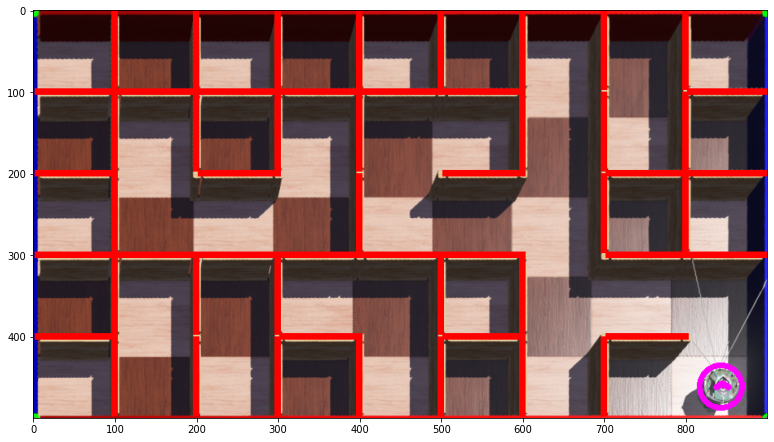

In [9]:
#robot position
#greyscale tresholding
H_thld_bot = np.array([125, 90, 245])
L_thld_bot = np.array([40, 1, 100])
tfs_hsv = cv2.cvtColor(tsf, cv2.COLOR_BGR2HSV)
#tresholding corner
robot_mask = cv2.inRange(tfs_hsv, L_thld_bot, H_thld_bot)
#mask_gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

mask = robot_mask.copy()
kernel = np.ones((2,2),np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
kernel = np.ones((10,10),np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
kernel = np.ones((8,8),np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
kernel = np.ones((2,2),np.uint8)
mask = cv2.dilate(mask, kernel, iterations = 1)

opening_BGR = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
img_gray = cv2.cvtColor(opening_BGR, cv2.COLOR_BGR2GRAY)
img_rgb_origin = cv2.cvtColor(opening_BGR, cv2.COLOR_BGR2RGB)
edges = cv2.Canny(mask, threshold1 = 50, threshold2 = 100, apertureSize = 3)

#contour detection
img2, contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(tsf, contours, -1, (0,255,0), 3)
img_rgb = cv2.cvtColor(tsf, cv2.COLOR_BGR2RGB)

#calculate MoI
for i ,cnt in enumerate(contours):
    (x, y), r = cv2.minEnclosingCircle(cnt)
(x, y), r = cv2.minEnclosingCircle(cnt)
point = (int(x), int(y))
#point = np.int32(point)
r = np.int32(r)
print(x,y)
print(r)
thickness = 5
# draw circle and arrow
robot_maze = cv2.circle(maze_tf, point, r, (255,0,255), thickness) 
cv2.putText(robot_maze, head, (point[0]-9, point[1]+8),cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,255),thickness, cv2.LINE_AA)
plt.figure(figsize = (13.5, 7.5))
plt.imshow(robot_maze)
plt.show()

In [10]:
# Printing and Writing Map
nrow = 5
ncol = 9
startcol = math.floor(point[0]/100)
startrow = math.floor(point[1]/100) 
print(startrow, startcol, heading)

hWall[0] = 1
hWall = np.concatenate((hWall, [np.ones(ncol)]), axis=0)

for i in range(5):
    vWall[i][0] = 1
vWall = np.concatenate((vWall, np.ones((nrow,1))), axis=1)

# Draw map
file1 = open("../MapFound.txt","w+") 
st = ""
for i in range(nrow*2+1):
    if i%2 == 1: # if odd row
        for j in range(ncol*2+1):
            if j%2 == 1: #if odd col
                if (i-1)//2 == startrow and (j-1)//2 == startcol:
                    if heading == 0:
                        st += "^ "
                    elif heading == 1:
                        st += "> "
                    elif heading == 2:
                        st += "v "
                    elif heading == 3:
                        st += "< "
                else:
                    st += "  "
            else:
                if vWall[i//2][j//2] == 1:
                    st += "| "
                else:
                    st += "  "
    else:
        st += " "
        for j in range(ncol):
            if hWall[i//2][j] == 1: 
                st += "---"
            else:
                st += "   "
            st += " "
    st += "\n"

# write out string
file1.write(st)
file1.close()                               

4 8 0
